In [1]:
import pandas
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt

We begin by loading our full consolidated dataset:

In [2]:
players_df = pandas.read_csv("data/consolidated_players_dataset.csv")
players_df.head()

,2018-19,2019-20,2020-21,2021-22,2022-23,2023-24,2P,2P%,2PA,3P,...,ORB,PF,PTS,Player,Pos,STL,Signed Using,TOV,TRB,eFG%
0,30431854,37800000,40824000,43848000,46872000,0,5.4,0.53,10.1,3.7,...,0.6,2.3,30.4,James Harden,SG,1.8,Bird Rights,4.4,5.4,0.54
1,6041520,7059480,8930242,0,0,0,4.3,0.46,9.3,0.7,...,1.2,2.8,13.1,Josh Jackson,SF,1.0,1st Round Pick,1.9,4.5,0.45
2,1544951,2305057,0,0,0,0,0.7,0.47,1.5,0.0,...,0.3,0.9,1.7,Damian Jones,C,0.1,1st Round pick,0.3,0.9,0.47
3,13045455,11954546,10863637,0,0,0,1.6,0.52,3.1,2.5,...,0.3,2.2,11.5,Joe Ingles,SF,1.1,Bird Rights,1.9,4.2,0.61
4,1740000,2033160,3665787,0,0,0,0.9,0.47,1.9,0.0,...,0.6,1.4,2.3,Caleb Swanigan,PF,0.2,1st Round Pick,0.7,2.0,0.41


# Implementation of the Perceptron Algorithm

In [3]:
def perceptron_update(x,y,w):
    """
    Helper function to update the current weight vector in the perceptron algorithm.
    
    Input:
    x: input vector of size d x 1
    y: corresponding label (-1 or +1)
    w: weight vector of size d x 1
    
    Output:
    w : weight vector after updating, of size d x 1
    """
    w += y*x
    return w.flatten()

In [4]:
def perceptron(x,y,max_iterations):
    """
    Function that executes the perceptron algorithm. 
    If the algorithm does not converge in max_iterations iterations,
    this function will terminate anyways, and return the current
    values of w and b.
    
    Input:
    x: input vectors of size n x d
    y: corresponding labels (each of which is either -1 or +1); size n x 1
    
    Output:
    w : weight vector of size 1xd
    b : bias term
    """
    n, d = x.shape
    
    x_with_offset = np.append(x,np.ones((n,1)), 1)
    w_with_offset = np.zeros(d+1)
    num_iterations = 0
    
    while num_iterations < max_iterations:
        # derive an array of n elements, such that products[i] = (y_i)(w*(x_i))
        products = np.sum(y * np.transpose(x_with_offset * w_with_offset), axis=0)
        
        # array of indices of misclassified data points
        misclassified_indices = np.nonzero(products <= 0)[0]
        
        # check if no mislassified data points exist, in which case we exit loop
        if len(misclassified_indices) == 0:
            break
        
        # randomly select index of data point to update w
        update_index = np.random.choice(misclassified_indices)
        
        w_with_offset = perceptron_update(x_with_offset[update_index], y[update_index], w_with_offset)
        num_iterations += 1
    
    w = w_with_offset[:-1]
    b = w_with_offset[-1]
    return (w,b)

In [5]:
def plot_perceptron(points, ys, w, b, season, xlabel, ylabel):
    """
    Helper function to plot the data points (colored based on classification specified in ys),
    as well as the classification boundary determined by the perceptron algorithm.
    
    Input:
    points: data points for a given season
    ys: corresponding labels
    w: weight vector
    b: bias term
    season: string indicating NBA season in question
    xlabel: label for x-axis of graph
    ylabel: label for y-axis of graph
    """
    x0 = points[:,0]
    x1 = points[:,1]
    x_samples = [np.min(x0), np.max(x0)]
    plt.plot(x_samples, [-(w[0]*x + b)/w[1] for x in x_samples], label="classification boundary")
    plt.scatter(x0, x1, c=["blue" if y == 1 else "magenta" for y in ys])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(np.min(x1) - 0.25, np.max(x1) + 0.25)
    plt.legend()
    plt.title("Perceptron (" + season + " NBA season)")
    plt.show()

In [6]:
def run_season_perceptron(season, feature1, feature2, xlabel, ylabel):
    """
    Executes the perceptron algorithm for the given season, such that all
    data points are determined using the given features. Also plots 
    data points and the classification boundary output by the perceptron algorithm.
    
    Input:
    season: string indicating NBA season in question
    feature1: string indicating column name of first feature to focus on
    feature2: string indicating column name of second feature to focus on
    xlabel: label for x-axis of graph
    ylabel: label for y-axis of graph
    """
    # retrieving all players who had a contract running through this season
    contract_players = players_df[players_df[season] > 0]

    player_stats = np.array(contract_players[[feature1, feature2]])

    # where at_least_midlevel[i] = 1 if player i made 
    # at least the taxpayer's mid-level exception during this season; and 
    # at_least_midlevel[i] = -1 otherwise.
    at_least_midlevel = 2 * np.array(contract_players[season] >= 8600000) - 1
    
    # executing the perceptron algorithm with a limit of 1000 iterations
    w, b = perceptron(player_stats, at_least_midlevel, 1000)
    
    plot_perceptron(player_stats, at_least_midlevel, w, b, season, xlabel, ylabel)

# Execution of the Perceptron Algorithm

Having implemented the perceptron algorithm above, we now can utilize this algorithm to attempt checking whether our data is linearly separable. Specifically, for each NBA season for which we have contract information (i.e., for each season from 2018-19 to 2023-24, inclusive), we plot points per game (`PTS`) vs. efficient field goal percentage (`eFG%`) for every player that has a contract during that season. Each point on the plot is then categorized as $+1$ if its corresponding player earned at least the taxpayer's mid-level exception and $-1$ otherwise. (Note: The taxpayer's mid-level exception is a certain amount of money that is set annually by the NBA and is often utilized as a baseline approximation of the average NBA salary. This exception was set at \$8,600,000 for contracts starting in the 2018-19 NBA season; therefore, we utilize this value of \$8,600,000 throughout the rest of our study.) Classifying all data points in this fashion will then allow us to test whether our data is linearly separable—as linear separability here would imply a player's points per game and efficient field goal percentage can already be considered sufficient information to predict whether a player's salary meets the average salary baseline.

We begin with the 2018-19 NBA season:

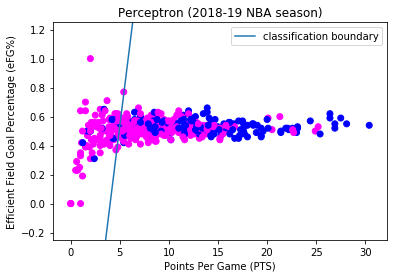

In [7]:
run_season_perceptron("2018-19", "PTS", "eFG%", "Points Per Game (PTS)", "Efficient Field Goal Percentage (eFG%)")

Clearly, even increasing the maximum number of iterations would not cause the perceptron algorithm to converge, since this data for the 2018-19 NBA season is not linearly separable. We now check if the perceptron algorithm converges on the data for any of the other seasons:

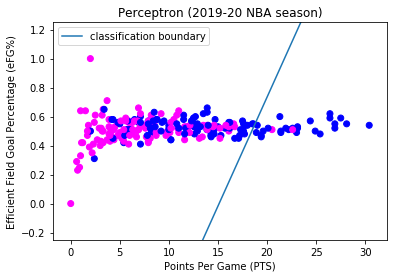

In [12]:
run_season_perceptron("2019-20", "PTS", "eFG%", "Points Per Game (PTS)", "Efficient Field Goal Percentage (eFG%)")

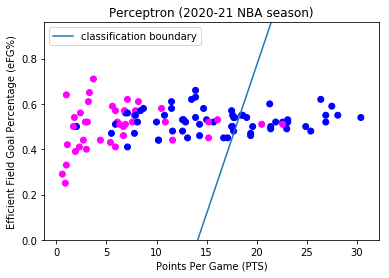

In [16]:
run_season_perceptron("2020-21", "PTS", "eFG%", "Points Per Game (PTS)", "Efficient Field Goal Percentage (eFG%)")

As seen above, the data for the 2019-20 and 2020-21 NBA seasons is not linearly separable either. However, we can note here that seasonal data is growing increasingly sparse with every year, which makes sense since long-term contracts are more difficult to obtain. More importantly, as the number of players with active contracts decreases every year, the perceptron algorithm gets progressively closer to converging.

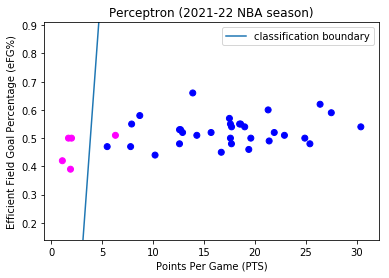

In [17]:
run_season_perceptron("2021-22", "PTS", "eFG%", "Points Per Game (PTS)", "Efficient Field Goal Percentage (eFG%)")

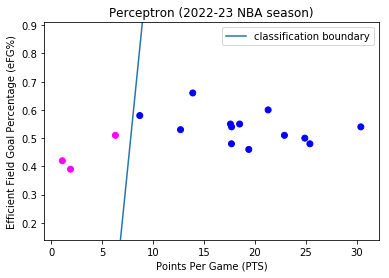

In [18]:
run_season_perceptron("2022-23", "PTS", "eFG%", "Points Per Game (PTS)", "Efficient Field Goal Percentage (eFG%)")

Here, we see the perceptron algorithm converge for the first time—specifically on data for the 2022-23 NBA season. However, there are only 16 players under contract during this season, which is far too small of a sample size to reach any firm conclusions regarding the linear separability of our data in general. For similar reasons, the 2023-24 NBA season is not considered here, since there are only 3 players in the dataset who would still be under contract during that season.

Instead, we argue that the failure of the perceptron algorithm to converge on data for any of the other earlier seasons convincingly indicates that our data is not linearly separable. This in turn implies that we cannot simply rely upon points per game and efficient field goal percentage to reliably predict whether a player will earn a contract at least as high as the average salary threshold discussed above. To confirm this pattern extends beyond the case of these two specific features, we test a few other cases below, using the 2018-19 season data since it accounts for the highest number of players:

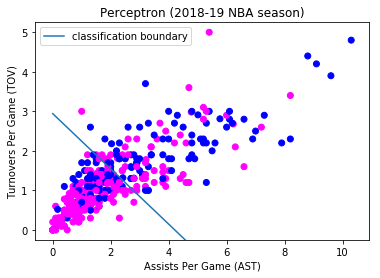

In [19]:
run_season_perceptron("2018-19", "AST", "TOV", "Assists Per Game (AST)", "Turnovers Per Game (TOV)")

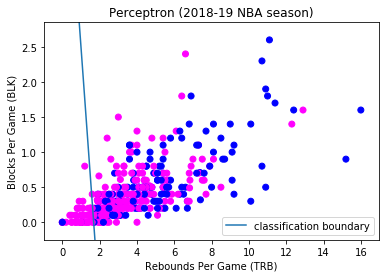

In [20]:
run_season_perceptron("2018-19", "TRB", "BLK", "Rebounds Per Game (TRB)", "Blocks Per Game (BLK)")

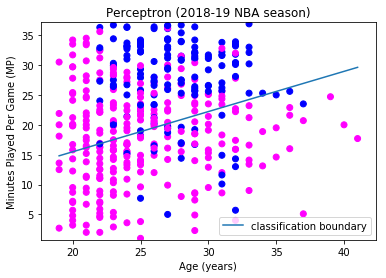

In [21]:
run_season_perceptron("2018-19", "Age", "MP", "Age (years)", "Minutes Played Per Game (MP)")

It appears that regardless of what pair of features we choose to focus on, the resulting data will not be linearly separable, highlighting the fact that an entire host of features factor into a player's salary as opposed to just two statistics. To more closely explore which features most strongly impact a player's salary, we now turn to more complex models beyond the perceptron algorithm.